<a href="https://colab.research.google.com/github/Msaleemakhtar/Deep-Learning-with-pytorch/blob/main/06_Vision_transformer(Vit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Replicating Vision Transformer(Vit) Paper with Pytorch**

Use mathpix.com (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
https://accounts.mathpix.com/login?return_to=https%3A%2F%2Fsnip.mathpix.com%2F


# ***Get the data***

In [70]:
# Check if CUDA (NVIDIA GPU) is available
# If CUDA is available, set the device to "cuda" to utilize the GPU
# If CUDA is not available, set the device to "cpu

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [71]:
# Download data
import os
import zipfile
import requests
from pathlib import Path

def download_data(source:str, destination:str, remove_source:bool=True)->Path:

  #setup path to data folder
  data_path = Path("data/")

  image_path = data_path/destination

  print("imagepath ", image_path)

  # if directory doesn't exist , download and prepare it
  if image_path.is_dir():
    print(f"[INFO]{image_path} already exist, skipp the download")

  else:
    print(f"[INFO] doesn't exist {image_path} downloading ........")
    image_path.mkdir(parents= True, exist_ok=True)

    # download steak, sushi, pizza
    target_file = Path(source).name

    with open(data_path/target_file, "wb") as f:
      print(f"[INFO] downloading {target_file} from {source}")
      request = requests.get(source)
      f.write(request.content)

      # unzip file
    with zipfile.ZipFile(data_path/target_file, "r") as ref_zip:
      print(f"[INFO] unzipping {target_file}..............")
      ref_zip.extractall(image_path)

    # remove .zip file
    if remove_source:

      os.remove(data_path/target_file)



  return image_path

In [72]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


imagepath  data/pizza_steak_sushi
[INFO]data/pizza_steak_sushi already exist, skipp the download


PosixPath('data/pizza_steak_sushi')

In [73]:
# setup directories for tain and test data
train_dir = image_path /'train'
test_dir = image_path/ 'test'

In [74]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [75]:
!pip install torchinfo

In [76]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torchinfo import summary
from torch.utils.data import DataLoader

# Pre_processing of Data

**1. IMAGE TRANSFORMATION**
 * a transformation pipeline created using torchvision.transforms.
 * transforms.Compose-----> is a function that allows you to chain multiple image transformations together.


 * transforms.Resize((IMG_SIZE, IMG_SIZE))--->
This transformation resizes the image to the dimensions specified by (IMG_SIZE, IMG_SIZE), which is (224, 224) in this case.
transforms.Resize ensures that all images fed into the neural network are of the same size, which is crucial for batch processing and consistency.

 * transforms.ToTensor()-->
This transformation converts the image to a PyTorch tensor.
transforms.ToTensor() also scales the pixel values from the range [0, 255] to [0, 1] by dividing by 255. This is important because neural networks typically work better with normalized input values.
In addition to normalization, it also rearranges the dimensions of the image from (H, W, C) (Height, Width, Channels) to (C, H, W), which is the format expected by PyTorch models.




In [77]:
#create a transform to prepare our images.

# training resolution is mentioned in Vit paper as being 224 (height=224, width=224).
IMG_SIZE = 224
#creare transform pipline manually
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()

])

manual_transform


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

2. Datasets and Dataloader

The DataLoader in PyTorch is a versatile and essential tool designed to efficiently handle and preprocess datasets for machine learning models. It simplifies the process of loading data by providing key features such as:

* Batch Loading: Automatically groups data into batches, enabling mini-batch gradient descent.

* Shuffling: Randomizes the order of data at each epoch to prevent the model from learning the order of the data.

* Parallel Data Loading: Uses multiple worker threads to load data in parallel, significantly speeding up the data loading process.
Automatic Batching: Combines individual data samples into batches, ensuring consistent data formats.

* Integration with Transformations: Applies specified data transformations on-the-fly as it loads each batch.
Custom Dataset Handling: Supports custom datasets by implementing torch.utils.data.Dataset, allowing for flexible and complex data loading logic.

Overall, DataLoader is critical for efficient data management and preprocessing in PyTorch, leading to faster and more effective training and evaluation of machine learning models.

* https://horace.io/brrr_intro.html (Making Deep Learning Go Brrrr From First Principles
)

In [78]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set the number of workers to the number of CPU cores available
NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       num_workers: int = NUM_WORKERS):
    """
    Creates DataLoaders for training and testing datasets.

    Args:
        train_dir (str): Path to the training data directory.
        test_dir (str): Path to the testing data directory.
        transform (transforms.Compose): Transformations to be applied to the images.
        batch_size (int): Number of samples per batch.
        num_workers (int, optional): Number of subprocesses to use for data loading. Defaults to the number of CPU cores.

    Returns:
        tuple: A tuple containing:
            - class_names (list): List of class names.
            - train_dataloader (DataLoader): DataLoader for the training dataset.
            - test_dataloader (DataLoader): DataLoader for the testing dataset.
    """

    # Setup ImageFolder for the training and testing datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names from the training data
    class_names = train_data.classes


    # Create DataLoader for the training data
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True  # Shuffle the data to ensure randomness during training
    )

    # Create DataLoader for the testing data
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=False  # Do not shuffle the data during testing
    )

    return train_dataloader, test_dataloader , class_names



In [79]:
# se the batch size
BATCH_SIZE = 32

# create data loader

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                        test_dir=test_dir,
                                                        transform=manual_transform,
                                                        batch_size=BATCH_SIZE)


train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d30c497fb20>,
 ['pizza', 'steak', 'sushi'])

In [80]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, class_names[label]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), 'pizza')

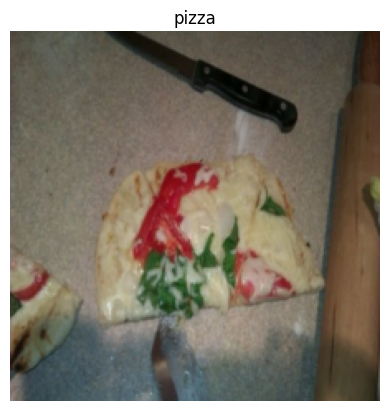

In [81]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# **Calculating Patch Embedding Input/Output Shape**

In [82]:
# Calculating the patches ofimage
height = 224 # H
width = 224  # W
color_channels = 3 # C
patch_size = 16 # P

#calculating N (Number of patches)
Number_of_patches =  int((height * width)/patch_size**2)

Number_of_patches


196

## Image Transformation

### Input
The image starts as 2D with size:
$$
H \times W \times C
$$

### Output
The image gets converted to a sequence of flattened 2D patches with size:
$$
N \times (P^2 \cdot C)
$$




In [83]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (Number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


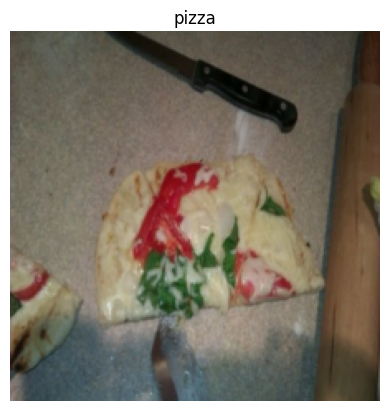

In [84]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

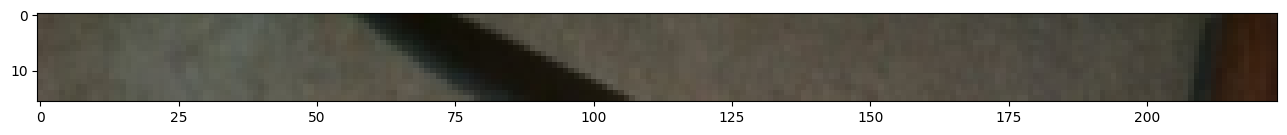

In [85]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

 Number of patches in a row : 14.0 , patch size is : (16 ,  16) pixels


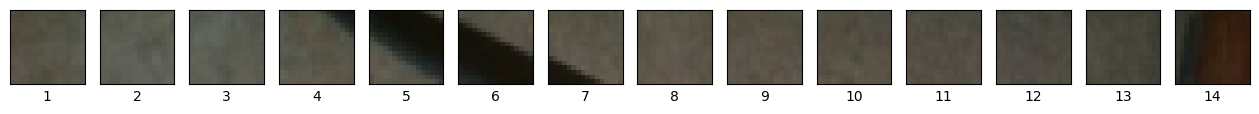

In [86]:
# Setup hyperparameters and make sure img_size and patch_size are compatible

img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(f" Number of patches in a row : {num_patches} , patch size is : ({patch_size} ,  {patch_size}) pixels")

# create subplots
fig , axs = plt.subplots(
                  nrows = 1,
                  ncols = img_size // patch_size,
                  figsize = (patch_size, patch_size),
                  sharex = True,
                  sharey = True)

# Iterate through number of patches in the top row
for i , patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

 Number of patches in a row : 14.0 , patch size is : (16 ,  16) pixels


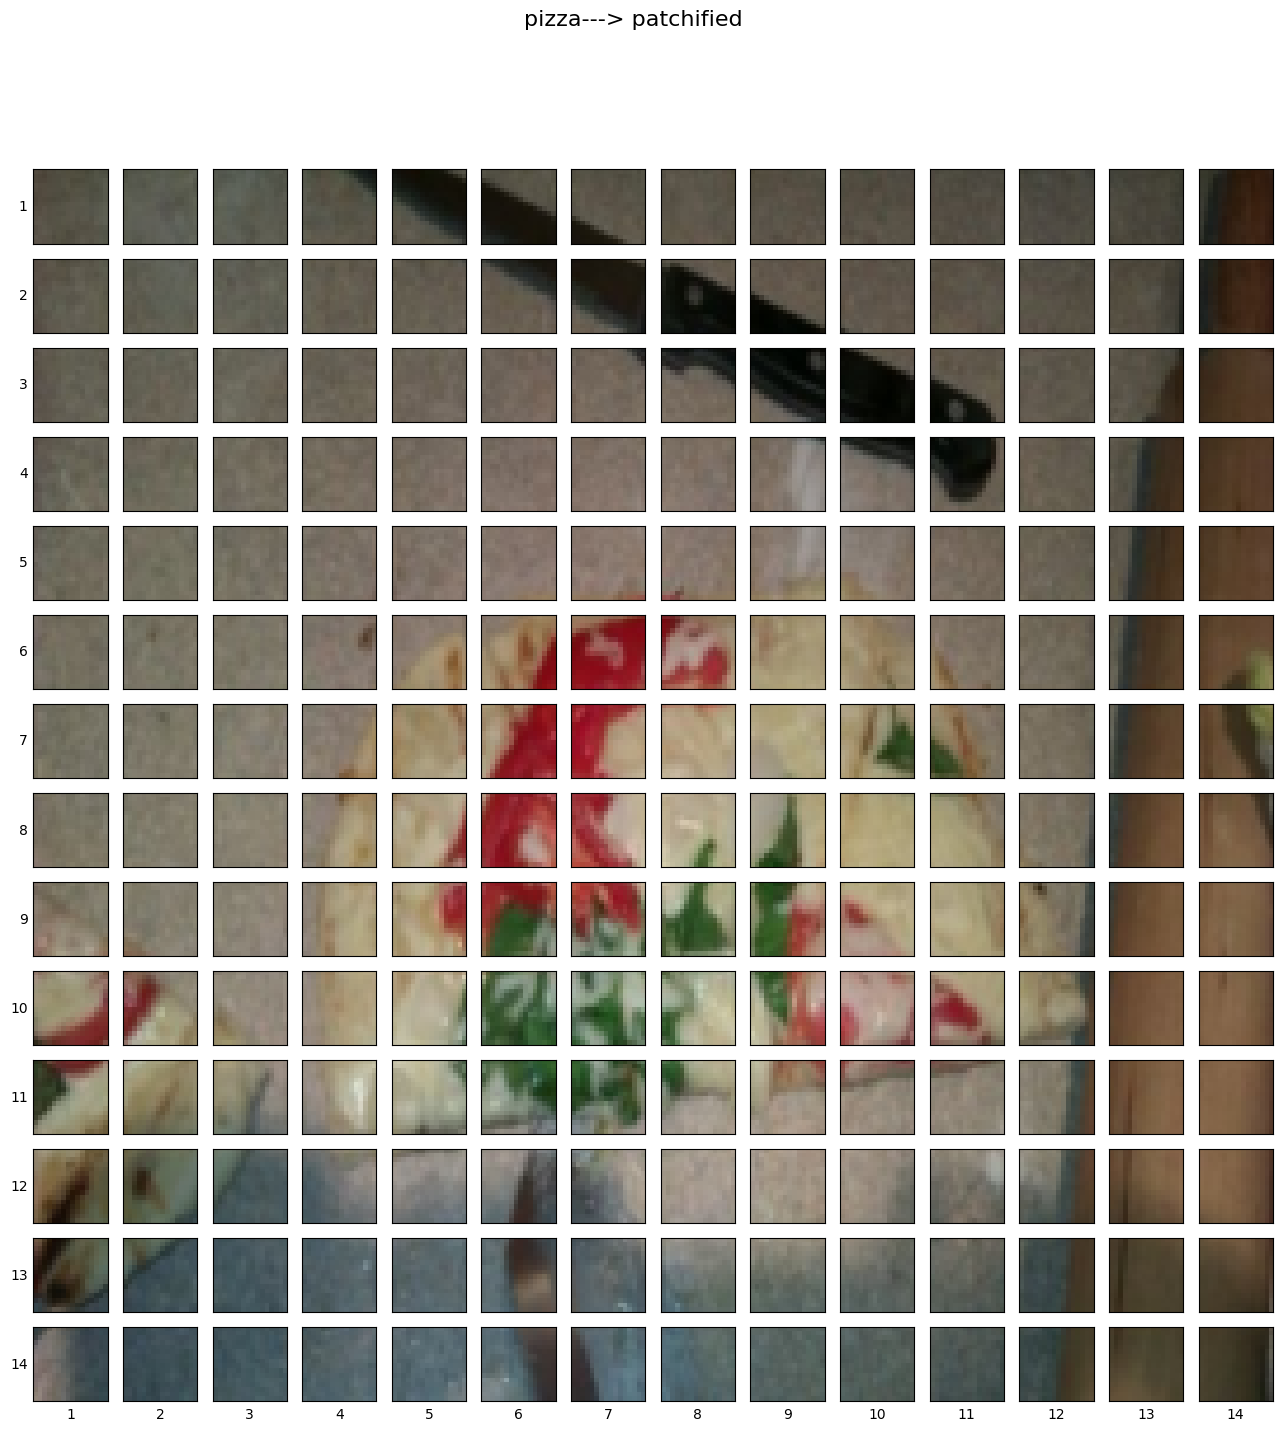

In [87]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0
print(f" Number of patches in a row : {num_patches} , patch size is : ({patch_size} ,  {patch_size}) pixels")

# create subplots
fig , axs = plt.subplots(
                  nrows = img_size //patch_size,
                  ncols = img_size // patch_size,
                  figsize = (patch_size, patch_size),
                  sharex = True,
                  sharey = True)
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j , patch_width in enumerate(range(0, img_size, patch_size)):

    # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

    # Set up label information, remove the ticks for clarity and set labels to outside
    axs[i,j].set_ylabel(i+1, rotation= "horizontal", horizontalalignment = "right", verticalalignment= "center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()


# setup the super title
fig.suptitle(f"{class_names[label]}---> patchified", fontsize= 16)
plt.show()



# ***`Creating image patches with torch.nn.Conv2d()`***

In [88]:
from torch import nn
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels:int=3, patch_size:int = 16, embedding_dim:int = 768):
    super().__init__()
    #Create a layer to turn image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # create flatten layer to conert patch feature into single dimension
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    # create forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0

    # Perform the forward pass
    x_patcher = self.patcher(x)

    print(" x_patcher ",  x_patcher.shape )

    x_flatten = self.flatten(x_patcher)

    print(" x_flatten ",  x_flatten.shape )

    # 6. Make sure the output shape has the right order
    return x_flatten.permute(0,2,1) # djust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [89]:
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [90]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
 x_patcher  torch.Size([1, 768, 14, 14])
 x_flatten  torch.Size([1, 768, 196])
Output patch embedding shape: torch.Size([1, 196, 768])


In [91]:
16*16*3

768

In [92]:
14*14

196

# **Summary of PatchEmbedding layer.**

In [93]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=25,
        row_settings=["var_names"])

 x_patcher  torch.Size([1, 768, 14, 14])
 x_flatten  torch.Size([1, 768, 196])


Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]          [1, 196, 768]             --                        True
├─Conv2d (patcher)                       [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
├─Flatten (flatten)                      [1, 768, 14, 14]          [1, 768, 196]             --                        --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

# **Creating the Class Token Embedding**

* To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the embedding_dimension (D
𝐷
) and then add it to the number_of_patches dimension.

 * **Note:** Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

In [94]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
# [batch_size, number_of_tokens, embedding_dimension]
# require_grad is True to make sure the embedding is learnable

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)

# show the first 10 examples
print(class_token[:,:,:10])

#vprint the shape of class token

print(f"class_token shape is :  {class_token.shape}---[batch_size, number_of_tokens, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class_token shape is :  torch.Size([1, 1, 768])---[batch_size, number_of_tokens, embedding_dimension]


**Note:** See how the number_of_tokens dimension of class_token is 1 since we only want to prepend one class token value to the start of the patch embedding sequence.

Now we've got the class token embedding, let's prepend it to our sequence of image patches, patch_embedded_image.

We can do so using torch.cat() and set dim=1 (so class_token's number_of_tokens dimension is preprended to patch_embedded_image's number_of_patches dimension).

In [95]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.3822, -0.0925, -0.0413,  ...,  0.0318, -0.1870,  0.2394],
         [ 0.4509, -0.0797, -0.0857,  ...,  0.0455, -0.2050,  0.2567],
         ...,
         [ 0.2912, -0.0470, -0.0201,  ...,  0.0117, -0.1203,  0.1457],
         [ 0.2965, -0.1057, -0.0325,  ...,  0.0160, -0.1426,  0.2165],
         [ 0.2216, -0.1083,  0.0117,  ...,  0.0087, -0.0839,  0.1088]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [96]:
patch_embedded_image

tensor([[[ 0.3822, -0.0925, -0.0413,  ...,  0.0318, -0.1870,  0.2394],
         [ 0.4509, -0.0797, -0.0857,  ...,  0.0455, -0.2050,  0.2567],
         [ 0.4327, -0.0766, -0.0761,  ...,  0.0579, -0.2115,  0.2378],
         ...,
         [ 0.2912, -0.0470, -0.0201,  ...,  0.0117, -0.1203,  0.1457],
         [ 0.2965, -0.1057, -0.0325,  ...,  0.0160, -0.1426,  0.2165],
         [ 0.2216, -0.1083,  0.0117,  ...,  0.0087, -0.0839,  0.1088]]],
       grad_fn=<PermuteBackward0>)

In [98]:
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

# **Creating Positional Embedding**

In [104]:
# Calculate N (Number of Patches)
num_of_patches = int((height * width)// patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
positional_embedding = nn.Parameter(torch.ones(1, num_of_patches +1, embedding_dimension), requires_grad=True)

print(positional_embedding[:,:10,:10])
print(positional_embedding.shape)


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 197, 768])


In [108]:
# Added Positional Embedding to patch_embedded_image_with_class_embedding

pached_and_position_embedding = patch_embedded_image_with_class_embedding + positional_embedding
# print first 10
print(pached_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {pached_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.3822, 0.9075, 0.9587,  ..., 1.0318, 0.8130, 1.2394],
         [1.4509, 0.9203, 0.9143,  ..., 1.0455, 0.7950, 1.2567],
         ...,
         [1.2912, 0.9530, 0.9799,  ..., 1.0117, 0.8797, 1.1457],
         [1.2965, 0.8943, 0.9675,  ..., 1.0160, 0.8574, 1.2165],
         [1.2216, 0.8917, 1.0117,  ..., 1.0087, 0.9161, 1.1088]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]
